In [1]:
from __future__ import print_function

import pickle
import numpy as np
import pandas as pd
import keras
from keras.preprocessing import sequence
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
import utils

%matplotlib inline
%load_ext autoreload

np.random.seed(7)

Using Theano backend.


# Load data and split for training

In [2]:
# Parameters needed for training.

p = {
  'top_words': 10000,    # Keep only these top words in the vocabular
  'max_length': 100,    # Max number of words in input sequence
  'embedding_dim': 128,
  'lstm_dim': 128,
  'dropout_U': 0.0,      # LSTM dropout prob
  'dropout_W': 0.0,      # LSTM dropout prob
  'keep_prob': 0.0,      # dense output layer dropout prob
  'batch_size': 128,
  'nb_epoch': 1,
  'feed_backwards': False,
  'bidirectional': False
}

In [3]:
# Read in data.

tag = 'no-stops'

# Read dataframe.
df = pd.read_pickle('final-dataframe-{}.pkl'.format(tag))

# Read in vocabulary dicts.
with open('data/final-vocab-{}.pkl'.format(tag), 'r') as f:
  _ = pickle.load(f)
  word2idx = _['word2idx']
  idx2word = _['idx2word']
  ranked_list = _['ranked_list']
  del _

In [4]:
# Split indexes into train and test sets (will let keras split validation data from the training set).  
# Use a fixed random state for reproducibility.

train_idx, test_idx = train_test_split(range(df.shape[0]), train_size=0.9, random_state=42)
len(train_idx), len(test_idx)

(21106, 2346)

In [5]:
# Helper function.

def filter_top_words(lst, top_words):
  for ix, item in enumerate(lst):
    lst[ix] = filter(lambda x: x < top_words, item)
  return lst

X_train = df.ix[train_idx, 'encoded_text'].tolist()
y_train = df.ix[train_idx, 'encoded_label'].tolist()
X_train = filter_top_words(X_train, p['top_words'])

X_test = df.ix[test_idx, 'encoded_text'].tolist()
y_test = df.ix[test_idx, 'encoded_label'].tolist()
X_test = filter_top_words(X_test, p['top_words'])

In [91]:
?sequence.pad_sequences

In [6]:
# Pad the sequences and truncated if necessary.

X_train = sequence.pad_sequences(X_train, maxlen=p['max_length'], value=p['top_words'], 
                                 padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=p['max_length'], value=p['top_words'],
                                padding='post', truncating='post')

if p['feed_backwards']:
  X_train = X_train[:, ::-1]
  X_test = X_test[:, ::-1]

X_train.shape, X_test.shape

((21106, 100), (2346, 100))

# Compile RNN

In [7]:
# Create/compile keras model.

model = utils.create_rnn_model_for_training(p)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 100, 128)      1280128     embedding_input_1[0][0]          
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           98688       embedding_1[0][0]                
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128)           0           gru_1[0][0]                      
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             129         dropout_1[0][0]                  
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_______________

In [8]:
# Fit model, keeping out 10% of original data for validation.

_ = model.fit(X_train, y_train, validation_split=1.*X_test.shape[0]/X_train.shape[0], 
              nb_epoch=p['nb_epoch'], batch_size=p['batch_size'])

Train on 18760 samples, validate on 2346 samples
Epoch 1/1
18760/18760 [==============================] - 39s - loss: 0.5735 - acc: 0.7079 - val_loss: 0.4952 - val_acc: 0.7741

In [9]:
# Accuracy on test set.

scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:2.2f}%'.format(scores[1]*100.))

Accuracy: 78.86%


In [10]:
# f1 score on test set.

y_test_pred = model.predict_classes(X_test).squeeze().tolist()
print('\nf1 score: {:2.2f}'.format(f1_score(y_test, y_test_pred)))
print('Baseline f1 score (guessing all 1\'s): {:2.2f}'.format(f1_score(np.ones_like(y_test), y_test)))

2336/2346 [============================>.] - ETA: 0s

In [11]:
# Save model and parameters

tag = ''
_ = model.save('gru{}.model'.format(base))
with open('gru{}.pkl'.format(base), 'w') as f:
  pickle.dump(p, f)

## Analysis

In [53]:
%%time

tag = ''

model = keras.models.load_model('gru{}.model'.format(tag))

with open('gru{}.pkl'.format(tag), 'r') as f:
  p = pickle.load(f)

CPU times: user 10.2 s, sys: 82.3 ms, total: 10.2 s
Wall time: 10.2 s


In [54]:
# Get probabilities associated with test set.

y_test_proba = model.predict_proba(X_test)

2336/2346 [============================>.] - ETA: 0s

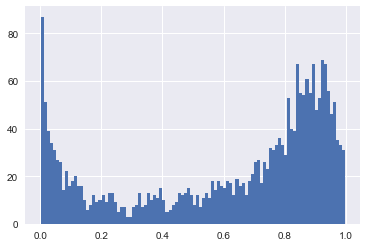

In [55]:
# Look at distribution.  There are some funny extreme modes we should try to understand...

_ = plt.hist(y_test_proba, 100)

In [56]:
# Pull out test set and add scores to dataframe.

df_test = df.loc[test_idx].copy()
df_test['prob'] = y_test_proba
df_test.head()

,text,label,url,domain,tokenized_text,encoded_text,encoded_label,prob
7806,Eight men now control as much wealth as the wo...,liberal,http://money.cnn.com/2017/01/15/news/economy/o...,cnn.com,man_NOUN control_VERB wealth_NOUN world_NOUN p...,"[54, 778, 2327, 71, 1178, 448, 2, 51, 20, 68, ...",1,0.905870
21569,7 lines to remember from Trump's joint addres...,liberal,http://abcnews.go.com/Politics/video/lines-rem...,go.com,line_NOUN remember_VERB trump_PROPN joint_ADJ ...,"[243, 891, 1, 1232, 454, 83, 1002, 424, 58, 21...",1,0.990690
21145,Trump said later that his administration was w...,liberal,http://www.cnn.com/2017/02/27/politics/donald-...,cnn.com,trump_PROPN say_VERB later_ADV administration_...,"[1, 0, 156, 15, 41, 8926, 274, 97, 6387, 768, ...",1,0.937333
4442,"Yes, the wall on our southwest border can and ...",conservative,http://www.breitbart.com/big-government/2017/0...,breitbart.com,yes_INTJ wall_NOUN southwest_NOUN border_NOUN ...,"[935, 366, 8230, 173, 294, 279, 1718, 3677, 59...",0,0.756864
5252,"WASHINGTON On Dec. 6, Chief Justice John G. R...",liberal,http://www.nytimes.com/2017/01/09/us/politics/...,nytimes.com,washington_PROPN chief_PROPN justice_PROPN joh...,"[30, 1060, 226, 154, 2543, 52, 7309, 732, 5201...",1,0.979550


In [57]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

df_test_mean = df_test.groupby('domain')['encoded_label', 'prob'].mean()
df_test_count = df_test.groupby('domain')['domain'].count()
df_test_stats = pd.concat([df_test_mean, df_test_count], axis=1).sort_values('prob')
df_test_stats['correct'] = df_test_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_test_stats

,encoded_label,prob,domain,correct
domain,,,,
westernjournalism.com,0,0.021077,71,True
rushlimbaugh.com,0,0.045937,2,True
freebeacon.com,0,0.172627,32,True
washingtontimes.com,0,0.188087,41,True
wfla.com,1,0.188905,1,False
twitchy.com,0,0.191324,17,True
wsj.com,0,0.212832,16,True
rightwingnews.com,0,0.228760,84,True
washingtonexaminer.com,0,0.299661,83,True


In [58]:
# Let's count the number of correct domain-level classifications.

df_test_stats.groupby('correct')['prob'].count()

correct
False     5
True     44
Name: prob, dtype: int64

In [59]:
# For the test set, let's generate a "time series" of the probability
# for a given article.

In [60]:
%autoreload

# Reload the model split as hidden and output layers.

model_emb, model_out = utils.split_model_layers(model, p)

text              ObamaCare was one of President Barack Obamas m...
label                                                  conservative
url               http://rightwingnews.com/top-news/americans-ju...
domain                                            rightwingnews.com
tokenized_text    obamacare_PROPN president_PROPN barack_PROPN o...
encoded_text      [282, 3, 247, 338, 1194, 205, 9849, 140, 4109,...
encoded_label                                                     0
prob                                                      0.0646958
Name: 5421, dtype: object


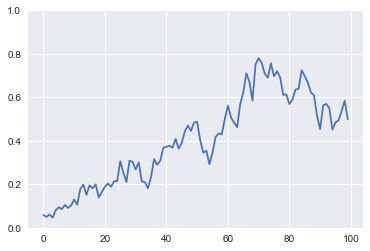

In [99]:
# Pick an article and plot the sequence of scores for each word.

idx = 47

seq = utils.evaluate_sequential_probs(X_test, idx, model_emb, model_out)
print(df_test.iloc[idx, :])

fig, axes = plt.subplots()
_ = plt.plot(seq)
_ = axes.set_ylim([0., 1.])

In [100]:
zip(range(len(seq)), seq, [idx2word[x] for x in X_test[idx, :].tolist()])

[(0, 0.058741018, 'obamacare_PROPN'),
 (1, 0.05012387, 'president_PROPN'),
 (2, 0.060968231, 'barack_PROPN'),
 (3, 0.047138311, 'obamas_PROPN'),
 (4, 0.081252955, 'main_ADJ'),
 (5, 0.094622478, 'war_NOUN'),
 (6, 0.085741475, 'cry_NOUN'),
 (7, 0.10526197, 'provide_VERB'),
 (8, 0.091335274, 'universal_ADJ'),
 (9, 0.10288507, 'healthcare_NOUN'),
 (10, 0.13023068, 'people_NOUN'),
 (11, 0.10637347, 'sound_VERB'),
 (12, 0.17902507, 'far_ADV'),
 (13, 0.19867869, 'good_ADJ'),
 (14, 0.15107597, 'refuse_VERB'),
 (15, 0.19564785, 'long_ADV'),
 (16, 0.18144166, 'dream_NOUN'),
 (17, 0.19987826, 'reality_NOUN'),
 (18, 0.13916712, 'huge_ADJ'),
 (19, 0.16449836, 'document_NOUN'),
 (20, 0.18882959, 'possibly_ADV'),
 (21, 0.20337436, 'read_VERB'),
 (22, 0.18864356, 'pass_VERB'),
 (23, 0.21394801, 'step_NOUN'),
 (24, 0.215105, 'socialist_ADJ'),
 (25, 0.30660859, 'economy_NOUN'),
 (26, 0.25318655, 'people_NOUN'),
 (27, 0.21027984, 'actually_ADV'),
 (28, 0.30927116, 'beneficial_ADJ'),
 (29, 0.3028453, 'peo